# Data Preprocessing Tools

## Importing the libraries

In [1]:
%pip install numpy pandas scikit-learn torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from numpy import array
from numpy import hstack
from numpy import array
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout, MaxPooling1D     
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error


## Importing the dataset

In [3]:
df = pd.read_csv('Data/Preprocessed Data/preprocessed_data.csv')

In [4]:
# Calculate mean of temperature and wind speed
df['temperature'] = df[['TMPMAX', 'TMPMIN']].mean(axis=1)
df['wind_speed'] = df[['wind_speed_8_30am', 'wind_speed_17_30pm']].mean(axis=1)

In [5]:
df.head()

,Year,Month,station_name,humidity,TMPMAX,TMPMIN,precipitation,wind_speed_8_30am,wind_speed_17_30pm,patients,Date,temperature,wind_speed
0,2007,1,Gampaha,85.838710,32.0,22.1,39.399999,12.5,14.50,64,2007-01-01,27.05,13.50
1,2007,1,Batticaloa,82.064516,28.4,24.0,170.100004,8.6,10.10,0,2007-01-01,26.20,9.35
2,2007,1,Colombo,82.258065,31.8,22.9,91.100001,5.7,6.00,244,2007-01-01,27.35,5.85
3,2007,1,Galle,89.612903,29.6,23.3,78.200000,2.2,6.90,22,2007-01-01,26.45,4.55
4,2007,1,Jaffna,81.886667,29.7,22.2,12.500000,5.3,7.12,0,2007-01-01,25.95,6.21


## 1. Colomco District

#### Selection of features

In [6]:
Colombo_df = df[df.station_name == 'Colombo' ]
Colombo_df = Colombo_df.sort_values('Date').copy()

In [7]:
Colombo_df['precipitation(t-3)'] = Colombo_df['precipitation'].shift(-3)
Colombo_df['humidity(t-2)'] = Colombo_df['humidity'].shift(-2)

In [8]:
Colombo_df.dropna(inplace=True)

In [9]:
Colombo_df.drop(columns=['Year', 'Month', 'station_name', 'Date', 
                         'TMPMAX', 'TMPMIN', 'wind_speed_8_30am', 
                         'wind_speed_17_30pm', 'humidity', 'precipitation'],inplace=True)
Colombo_df.head()

,patients,temperature,wind_speed,precipitation(t-3),humidity(t-2)
2,244,27.35,5.85,374.100007,85.806452
13,175,27.35,4.85,432.400013,91.433333
25,61,28.30,4.35,79.899999,84.709677
34,35,28.25,3.45,106.600000,85.566667
38,44,28.90,5.30,260.500001,86.516129


In [10]:
Colombo_df = Colombo_df.iloc[:, [3,4,1,2,0]]
Colombo_df.head()

,precipitation(t-3),humidity(t-2),temperature,wind_speed,patients
2,374.100007,85.806452,27.35,5.85,244
13,432.400013,91.433333,27.35,4.85,175
25,79.899999,84.709677,28.30,4.35,61
34,106.600000,85.566667,28.25,3.45,35
38,260.500001,86.516129,28.90,5.30,44


In [11]:
columns_to_normalize = ['temperature', 'wind_speed', 'precipitation(t-3)', 'humidity(t-2)']

# Normalize the selected columns
scaler = MinMaxScaler()
Colombo_df[columns_to_normalize] = scaler.fit_transform(Colombo_df[columns_to_normalize])

# Print the normalized DataFrame
Colombo_df.head()

,precipitation(t-3),humidity(t-2),temperature,wind_speed,patients
2,0.385011,0.675183,0.238806,0.595041,244
13,0.445028,0.935285,0.238806,0.429752,175
25,0.082149,0.624484,0.522388,0.347107,61
34,0.109636,0.664099,0.507463,0.198347,35
38,0.268067,0.707987,0.701493,0.504132,44


#### Splitting the dataset into the Training set and Test set

In [12]:
train_size = int(len(Colombo_df) * 0.9)
test_size = len(Colombo_df) - train_size
train_data, test_data = Colombo_df[:train_size], Colombo_df[train_size:]

In [13]:
print(Colombo_df.shape, train_data.shape, test_data.shape)

(201, 5) (180, 5) (21, 5)


#### Model Training - CNN


In [14]:
"""
split a multivariate sequence into samples 
"""
def split_sequences(sequences, n_steps):
  X, y = list(), list()
  for i in range(len(sequences)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the dataset
    if end_ix > len(sequences):
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)

In [15]:
train_data_array = train_data.values    # Convert DataFrame to NumPy array
print(train_data_array.shape)

(180, 5)


In [16]:
n_steps = 12     # choose a number of time steps
X_train, y_train = split_sequences(train_data_array, n_steps)        # convert into input/output
n_features = X_train.shape[2]     # the dataset knows the number of features
print(X_train.shape, y_train.shape)

(169, 12, 4) (169,)


In [17]:
print(y_train)

[ 239.  156.  147.  137.  135.  163.  126.   96.  145.  109.   79.   67.
   90.  155.  174.  140.  102.  304.  731.  805.  551.  198.  273.  380.
  195.  563.  451.  430.   92.  252.  431. 1112. 1045.  363.  192.  141.
  181.  265.  309.  320.  280.  631.  968. 1082. 1032.  443.  490.  288.
  799. 1470.  608.  390.  357.  133.  209.  555.  713.  382.  650.  132.
  480.  517.  522.  439.  411.  299.  484.  906.  771.  646.  325.  625.
 1097. 1065.  603.  659.  225.  574. 2059. 1728.  842.  696.  639. 1025.
 1719. 1066. 1446.  683.  253.  367.  536.  510.  633.  390.  469.  937.
 1008. 1050. 1897.  845.  390.  500.  307. 1261. 1799.  663.  583.  307.
 1011. 2978. 1489. 1803. 2316. 4084. 4034. 8809. 3620. 1066. 1008. 1131.
 1312. 1449.  615.  400.  478.  615.  957. 1903.  927.  406.  463.  700.
 1290. 1204.  989.  640.  720.  681.  876. 1867. 1670. 1764. 2236. 3369.
 3757. 2094. 1189.  534.   32.   48.  360.  235.  279.  225.  153.   79.
   74.  110.  115.  439.  318.  336.  389.  830.  1

#### Building the CNN

In [35]:
# Define the model
model = Sequential()

# Convolutional Layer
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))  # Adding dropout for regularization

# Additional Conv and Pool layers (if needed)
model.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

# Flattening the output
model.add(Flatten())

# Dense Layers
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Model summary
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 11, 64)         │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 4, 32)          │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 2, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 2, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 50)             │         3,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,005 (31.27 KB)

 Trainable params: 8,005 (31.27 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
model.fit(X_train, y_train, epochs=1000, verbose=0, batch_size=32)

In [ ]:
y_train_pred = model.predict(X_train)

mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)

print("Root Mean Squared Error (RMSE):", rmse_train)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Root Mean Squared Error (RMSE): 425.6696511369546


In [ ]:
X_test, y_test = split_sequences(test_data.values, n_steps)
print(X_test.shape, y_test.shape)

(10, 12, 4) (10,)


In [ ]:
y_test_pred = model.predict(X_test)

mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)

print("Root Mean Squared Error (RMSE):", rmse_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Root Mean Squared Error (RMSE): 542.7499210526896


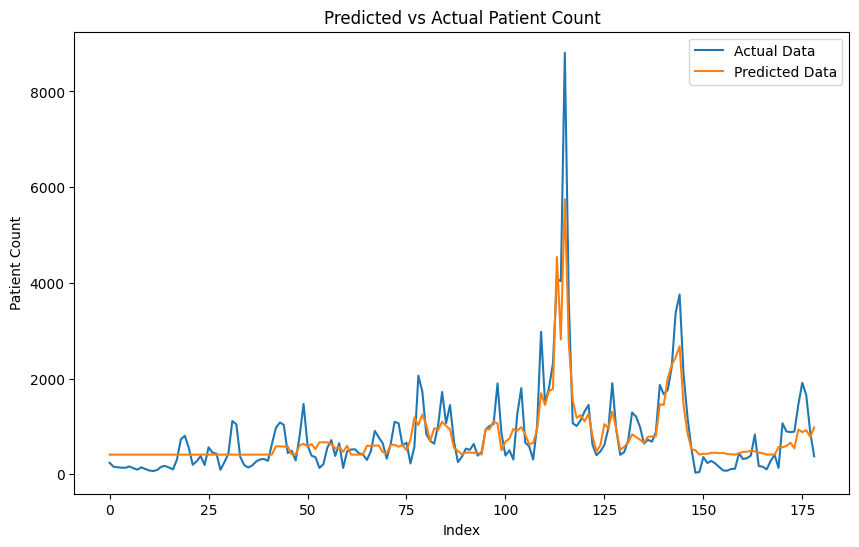

In [ ]:
y_actual = np.concatenate((y_train, y_test))
y_predicted = np.concatenate((y_train_pred, y_test_pred))

plt.figure(figsize=(10, 6))

plt.plot(y_actual, label='Actual Data')
plt.plot(y_predicted, label='Predicted Data')

plt.xlabel('Index')
plt.ylabel('Patient Count')
plt.title('Predicted vs Actual Patient Count')
plt.legend()
plt.show()